# HEP Benchmark Query Q6

This follows the [IRIS-HEP benchmark](https://github.com/iris-hep/adl-benchmarks-index)
and the article [Evaluating Query Languages and Systems for High-Energy Physics Data](https://arxiv.org/abs/2104.12615)
and provides implementations of the benchmark tasks using Apache Spark.

The workload and data:
  - Benchmark jobs are implemented according to the [IRIS-HEP benchmark](https://github.com/iris-hep/adl-benchmarks-index)
  - The input data is a series of events from CMS opendata
  - The job output is typically a histogram 
  - See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

Author and contact: Luca.Canali@cern.ch  
February, 2022


In [1]:
# Download the data if not yet available locally

# Download the reduced data set (2 GB)
! wget -r -np -R "index.html*" -e robots=off https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012B_SingleMu_sample.parquet/

# This downloads the full dataset (16 GB)
# ! wget -r -np -R "index.html*" -e robots=off https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012B_SingleMu.parquet/

In [2]:
# Install PySpark and sparkhistogram if needed
# ! pip install pyspark
! pip install sparkhistogram

In [3]:
# Note: if you cannot install the package sparkhistogram, 
# create the computeHistogram function as detailed at the end of this notebook.
# See https://github.com/LucaCanali/Miscellaneous/blob/master/Spark_Notes/Spark_DataFrame_Histograms.md 

from sparkhistogram import computeHistogram

In [ ]:
# Start the Spark Session
# This uses local mode for simplicity

# The use of findspark is optional
# import findspark
# findspark.init("/home/luca/Spark/spark-3.5.1-bin-hadoop3")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("HEP benchmark")
         .master("local[4]")
         .config("spark.driver.memory", "8g")
         .config("spark.jars", "./scalaudf_2.12-0.1.jar")  # jar with the Scala UDFs
         .config("spark.jars.packages", "net.jafama:jafama:2.3.2")  # Faster math library for Scala UDFs
         .getOrCreate()
        )


In [5]:
# Read data for the benchmark tasks
# download data as detailed at https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

path = "sparkdltrigger.web.cern.ch/sparkdltrigger/"
input_data = "Run2012B_SingleMu_sample.parquet"

# use this if you downloaded the full dataset
# input_data = "Run2012B_SingleMu.parquet"

df_events = spark.read.parquet(path + input_data)

df_events.printSchema()

print(f"Number of events: {df_events.count()}")

root
 |-- run: integer (nullable = true)
 |-- luminosityBlock: long (nullable = true)
 |-- event: long (nullable = true)
 |-- HLT_IsoMu24_eta2p1: boolean (nullable = true)
 |-- HLT_IsoMu24: boolean (nullable = true)
 |-- HLT_IsoMu17_eta2p1_LooseIsoPFTau20: boolean (nullable = true)
 |-- PV_npvs: integer (nullable = true)
 |-- PV_x: float (nullable = true)
 |-- PV_y: float (nullable = true)
 |-- PV_z: float (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Muon_pfRelIso03_all: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- 

# Q6 - Solution 1: Offload all computations to Scala UDF
For events with at least three jets, plot the $𝑝_𝑇$ of the trijet
system four-momentum (i.e., any combination of three distinct jets within the same event) that has the invariant mass closest to 172.5 GeV in each event and plot the maximum
b-tagging discriminant value among the jets in this trijet.


In [6]:
# Select 3-Jet events and group Jet parameters together

df_events_q6 = ( df_events
                 .selectExpr("event", "arrays_zip(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_btag) as Jet")
                 .filter("nJet >= 3")
               )
                
df_events_q6.printSchema()

root
 |-- event: long (nullable = true)
 |-- Jet: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Jet_pt: float (nullable = true)
 |    |    |-- Jet_eta: float (nullable = true)
 |    |    |-- Jet_phi: float (nullable = true)
 |    |    |-- Jet_mass: float (nullable = true)
 |    |    |-- Jet_btag: float (nullable = true)



In [7]:
# Register the Scala UDF
schema = "pt: float, btag: float"

spark.udf.registerJavaFunction("triJetSelectedPtBtag", "ch.cern.udf.triJetSelectedPtBtag", schema)

In [8]:
q6 = df_events_q6.selectExpr("triJetSelectedPtBtag(Jet) as trijet")

q6.printSchema()
q6.show(5, False)

root
 |-- trijet: struct (nullable = true)
 |    |-- pt: float (nullable = true)
 |    |-- btag: float (nullable = true)

+-----------------------+
|trijet                 |
+-----------------------+
|{21.191969, -1.0}      |
|{11.904238, 0.92060655}|
|{67.30781, 0.09140313} |
|{50.762405, 0.19420531}|
|{35.210625, 0.9639855} |
+-----------------------+
only showing top 5 rows



In [9]:
# Compute the histogram of trijet.btag
# The Spark function "width_bucket" is used to generate the histogram bucket number
# a groupBy operation with count is used to fill the histogram
# The result is a histogram with bins value and counts foreach bin (N_events)

min_val = 0
max_val = 1.0
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = computeHistogram(q6, "trijet.btag", min_val, max_val, num_bins) 


In [10]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 328 ms, sys: 39.2 ms, total: 367 ms
Wall time: 1min 57s


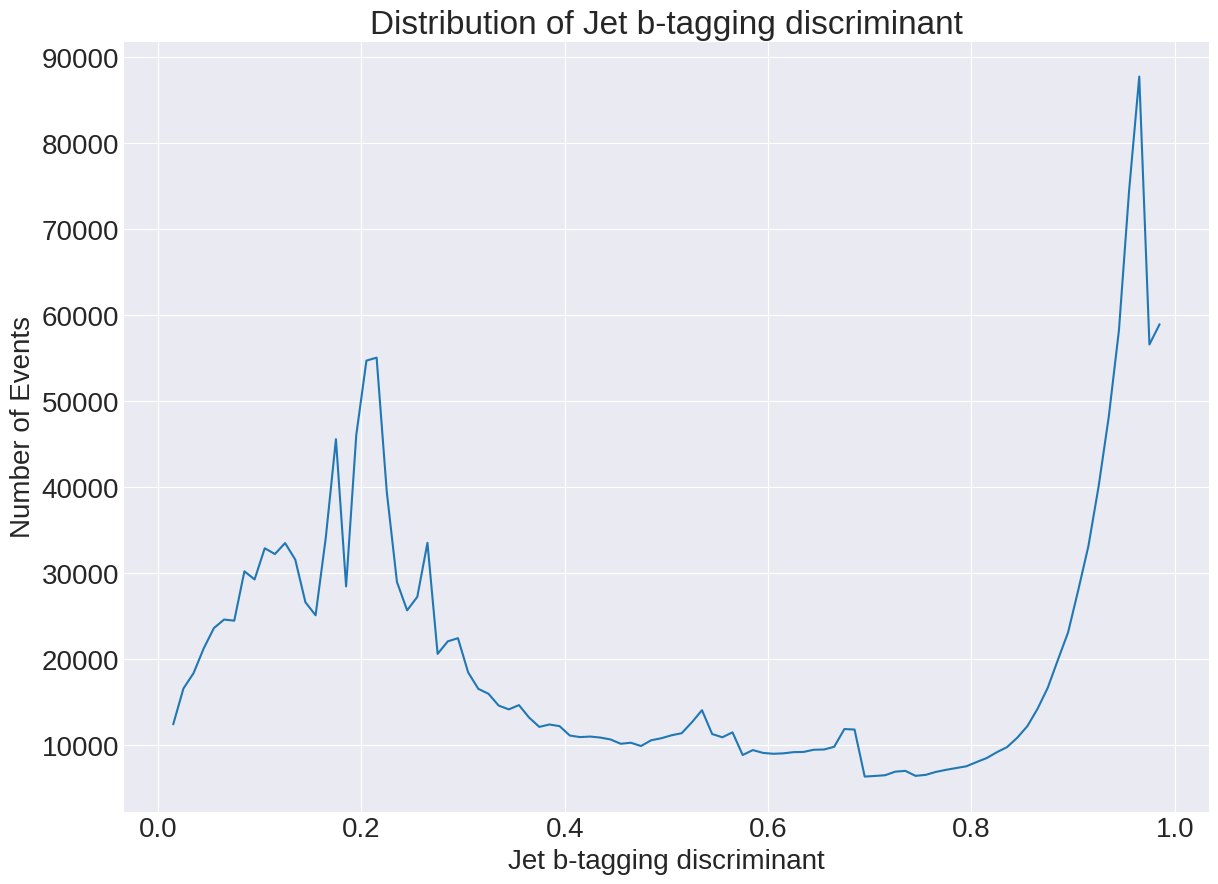

In [11]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["count"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('Jet b-tagging discriminant')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of Jet b-tagging discriminant")

plt.show()

In [12]:
# compute the histogram of trijet.pt

min_val = 0
max_val = 200
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = computeHistogram(q6, "trijet.pt", min_val, max_val, num_bins) 


In [13]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 33.5 ms, sys: 6.96 ms, total: 40.5 ms
Wall time: 1min 53s


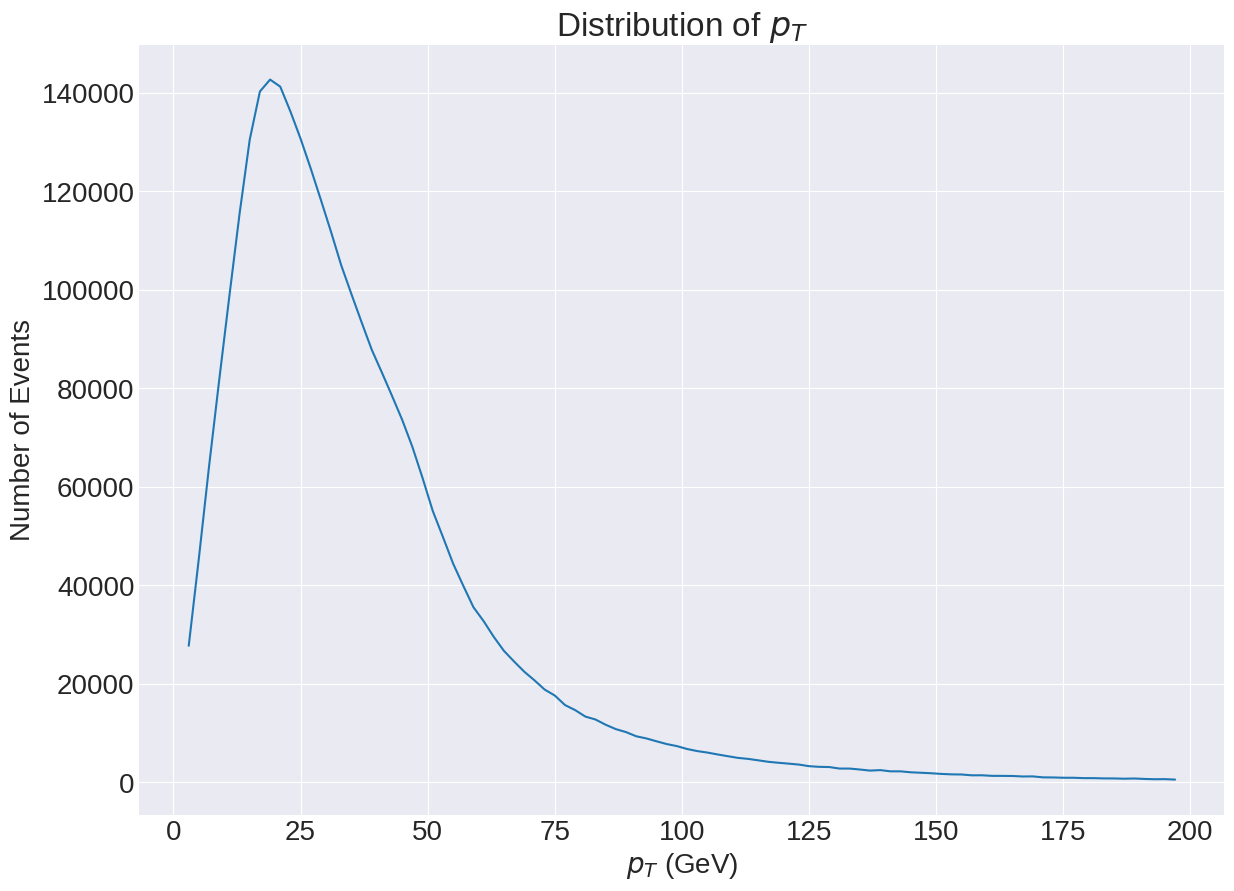

In [14]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["count"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('$p_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of $p_T$ ")

plt.show()

# Q6 - Solution 2: Compute 3-jet combinations and TriJet mass in Scala UDF
For events with at least three jets, plot the $𝑝_𝑇$ of the trijet
system four-momentum (i.e., any combination of three distinct jets within the same event) that has the invariant mass closest to 172.5 GeV in each event and plot the maximum
b-tagging discriminant value among the jets in this trijet.


In [15]:
# Select 3-Jet events and group Jet parameters together

df_events_q6 = ( df_events
                 .selectExpr("event", "arrays_zip(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_btag) as Jet")
                 .filter("nJet >= 3")
               )
                
df_events_q6.printSchema()


root
 |-- event: long (nullable = true)
 |-- Jet: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Jet_pt: float (nullable = true)
 |    |    |-- Jet_eta: float (nullable = true)
 |    |    |-- Jet_phi: float (nullable = true)
 |    |    |-- Jet_mass: float (nullable = true)
 |    |    |-- Jet_btag: float (nullable = true)



In [16]:
# Register the Scala UDF

# Alternative schema definition
#from pyspark.sql.types import FloatType, ArrayType, StructType, StructField
#
#schema = ArrayType(ArrayType(StructType([
#    StructField('pt', FloatType(), nullable=True),
#    StructField('eta', FloatType(), nullable=True),
#    StructField('phi', FloatType(), nullable=True),
#    StructField('mass', FloatType(), nullable=True)
#])))

schema = "array<array<struct<Jet_pt:float, Jet_eta:float, Jet_phi:float, Jet_mass:float, Jet_btag:float>>>"

spark.udf.registerJavaFunction("array_combinations", "ch.cern.udf.array_combinations", schema)

In [17]:
# use the Scala UDF to produce the trijet combinations
df_jet_combinations = df_events_q6.selectExpr("array_combinations(Jet) as Jet_combinations")

df_jet_combinations.printSchema()


root
 |-- Jet_combinations: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- Jet_pt: float (nullable = true)
 |    |    |    |-- Jet_eta: float (nullable = true)
 |    |    |    |-- Jet_phi: float (nullable = true)
 |    |    |    |-- Jet_mass: float (nullable = true)
 |    |    |    |-- Jet_btag: float (nullable = true)



In [18]:
# Register the Scala UDF
from pyspark.sql.types import StructType, StructField, FloatType

schema = "struct<mass:float, pt:float, btag:float>"

spark.udf.registerJavaFunction("compute_triJet_pt_mass_delta_btag", "ch.cern.udf.triJetPtMassDeltaBtag", schema )


In [19]:
# Compute the triJet btag using a Scala UDF

df2 = df_jet_combinations.selectExpr("""
transform(Jet_combinations, trijet -> compute_triJet_pt_mass_delta_btag(trijet)) as trijet
""")

df2.printSchema()
# df2.show(3, False)

root
 |-- trijet: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- mass: float (nullable = true)
 |    |    |-- pt: float (nullable = true)
 |    |    |-- btag: float (nullable = true)



In [20]:
q6 = df2.selectExpr("array_min(trijet) as trijet")

q6.printSchema()
q6.show(5, False)
q6.count()

root
 |-- trijet: struct (nullable = true)
 |    |-- mass: float (nullable = true)
 |    |-- pt: float (nullable = true)
 |    |-- btag: float (nullable = true)

+----------------------------------+
|trijet                            |
+----------------------------------+
|{23.817657, 21.191969, -1.0}      |
|{69.457016, 11.904238, 0.92060655}|
|{203.42136, 67.30781, 0.09140313} |
|{6.258835, 50.762405, 0.19420531} |
|{12.777115, 35.210625, 0.9639855} |
+----------------------------------+
only showing top 5 rows



3046954

In [21]:
# compute the histogram

min_val = 0
max_val = 1
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = computeHistogram(q6, "trijet.btag", min_val, max_val, num_bins) 


In [22]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 57.8 ms, sys: 9.56 ms, total: 67.4 ms
Wall time: 4min 37s


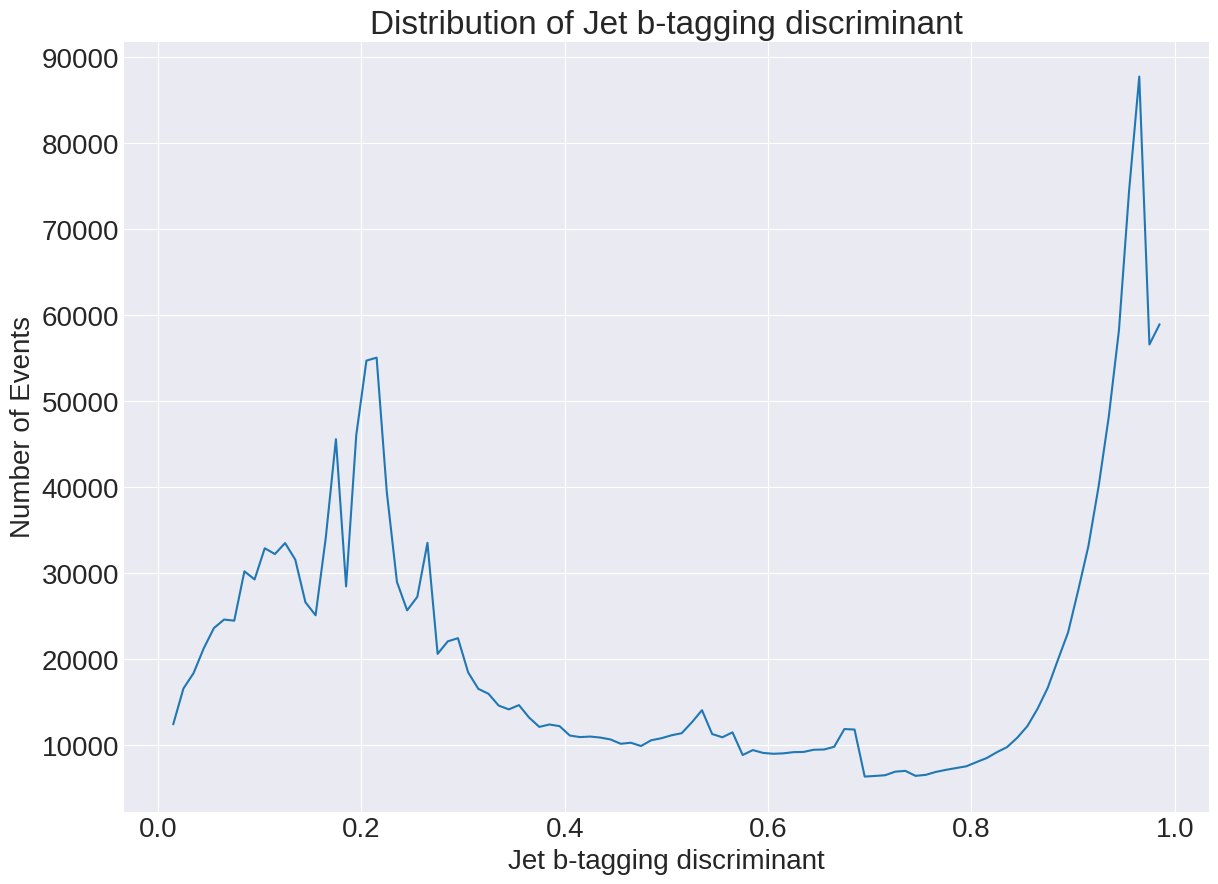

In [23]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["count"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('Jet b-tagging discriminant')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of Jet b-tagging discriminant")

plt.show()

In [24]:
# compute the histogram

min_val = 0
max_val = 200
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = computeHistogram(q6, "trijet.pt", min_val, max_val, num_bins) 


In [25]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 51.5 ms, sys: 15 ms, total: 66.4 ms
Wall time: 4min 35s


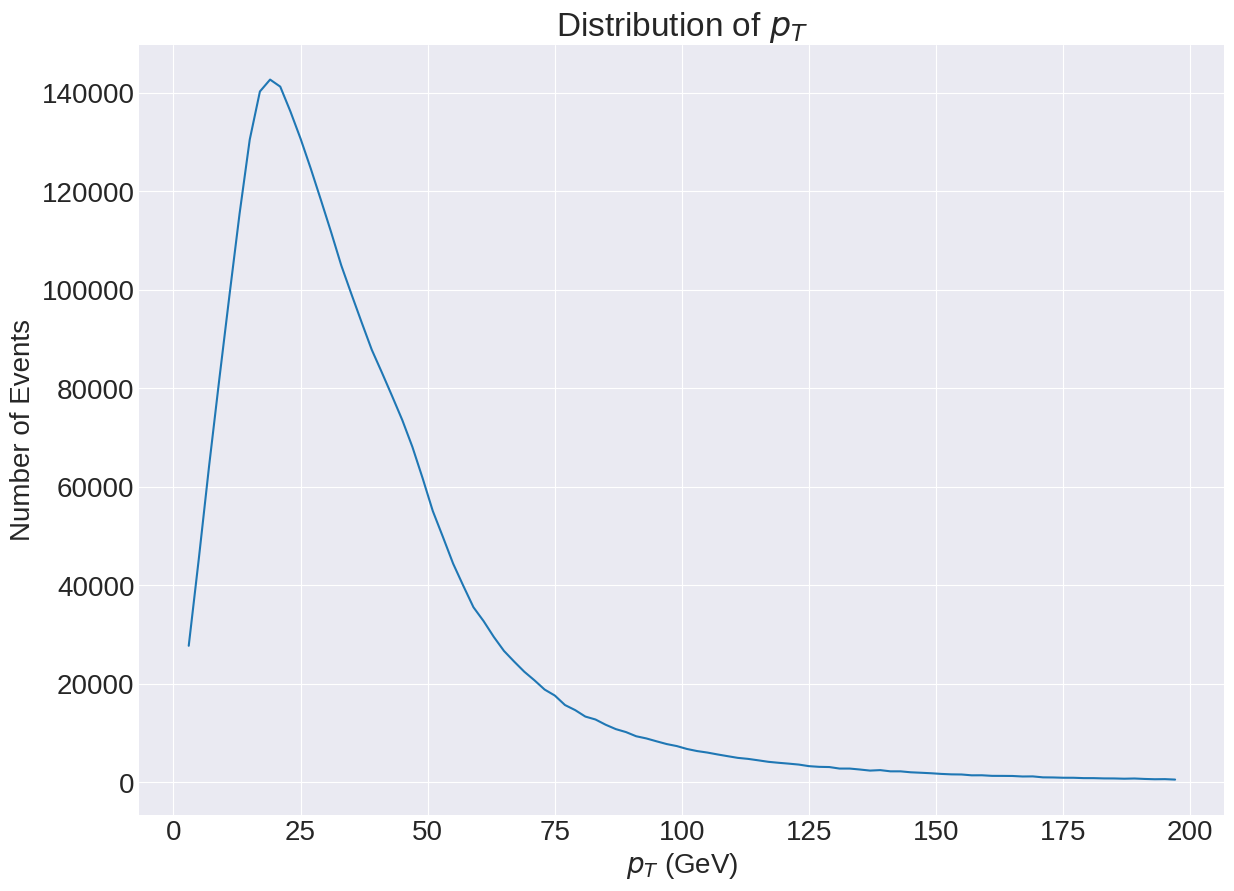

In [26]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["count"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('$p_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of $p_T$ ")

plt.show()

# Q6 - Solution 3: Only TriJet mass in Scala UDF
For events with at least three jets, plot the $𝑝_𝑇$ of the trijet
system four-momentum (i.e., any combination of three distinct jets within the same event) that has the invariant mass closest to 172.5 GeV in each event and plot the maximum
b-tagging discriminant value among the jets in this trijet.


In [27]:
# Select 3-Jet events and group Jet parameters together

df_events_q6 = ( df_events
                 .selectExpr("event", 
                             "arrays_zip(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_btag) as Jet")
                 .filter("nJet >= 3")
               )
                
df_events_q6.printSchema()


root
 |-- event: long (nullable = true)
 |-- Jet: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Jet_pt: float (nullable = true)
 |    |    |-- Jet_eta: float (nullable = true)
 |    |    |-- Jet_phi: float (nullable = true)
 |    |    |-- Jet_mass: float (nullable = true)
 |    |    |-- Jet_btag: float (nullable = true)



In [28]:
df_events_q6.selectExpr("posexplode(Jet) as (pos, Jet)").show(5, False)

+---+----------------------------------------------------+
|pos|Jet                                                 |
+---+----------------------------------------------------+
|0  |{28.03698, -2.573142, -0.0039507723, 9.169433, -1.0}|
|1  |{20.425129, -0.6191127, 2.44285, 6.7956524, -1.0}   |
|2  |{18.646175, 2.5256636, 1.2553711, 5.9932246, -1.0}  |
|3  |{17.995762, -3.8685246, 1.146259, 5.420945, -10.0}  |
|4  |{17.04349, -3.4595842, 2.2116172, 5.1888537, -10.0} |
+---+----------------------------------------------------+
only showing top 5 rows



In [29]:
schema = "struct<mass:float, pt:float, btag: float>"

spark.udf.registerJavaFunction("compute_triJet_pt_mass_btag", "ch.cern.udf.triJetPtMassBtag", schema )

In [30]:
df_events_q6.createOrReplaceTempView("t1")

24/05/07 16:12:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [31]:
# explodes Jet data for all possible 3-jet combinations
# compute pt and mass with a UDF 
# filter for the desired combination

df_3jets = spark.sql("""
with triJet_all as (
  select e1 as event, compute_triJet_pt_mass_btag(j1.Jet, j2.Jet, j3.Jet) as triJet_pt_mass_btag
  from
    (select event e1, posexplode(Jet) as (pos, Jet) from t1) j1,
    (select event e2, posexplode(Jet) as (pos, Jet) from t1) j2,
    (select event e3, posexplode(Jet) as (pos, Jet) from t1) j3
  where
    j1.pos < j2.pos and j2.pos < j3.pos
    and e1 = e2 and e1 = e3
)
select event, triJet_pt_mass_btag, 
       rank() over (partition by event order by abs(triJet_pt_mass_btag.mass - 172.5)) triJet_rank
from triJet_all
""")


#df_3jets.show(10, False)

In [32]:
df_3jets_selected = df_3jets.filter("triJet_rank == 1")

df_3jets_selected.printSchema()
df_3jets_selected.show(5, False)


root
 |-- event: long (nullable = true)
 |-- triJet_pt_mass_btag: struct (nullable = true)
 |    |-- mass: float (nullable = true)
 |    |-- pt: float (nullable = true)
 |    |-- btag: float (nullable = true)
 |-- triJet_rank: integer (nullable = false)



+-----+----------------------------------+-----------+
|event|triJet_pt_mass_btag               |triJet_rank|
+-----+----------------------------------+-----------+
|47430|{169.13412, 56.775955, 0.04395841}|1          |
|50104|{183.86757, 38.0367, -1.0}        |1          |
|63012|{231.37935, 19.84785, 0.939022}   |1          |
|70734|{172.78848, 31.175726, 0.93264025}|1          |
|84492|{65.63297, 30.16877, -10.0}       |1          |
+-----+----------------------------------+-----------+
only showing top 5 rows



In [34]:
# compute the histogram

min_val = 0
max_val = 1
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = computeHistogram(df_3jets_selected, "triJet_pt_mass_btag.btag", min_val, max_val, num_bins) 


In [35]:
%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 53.2 ms, sys: 9.59 ms, total: 62.8 ms
Wall time: 1min 58s


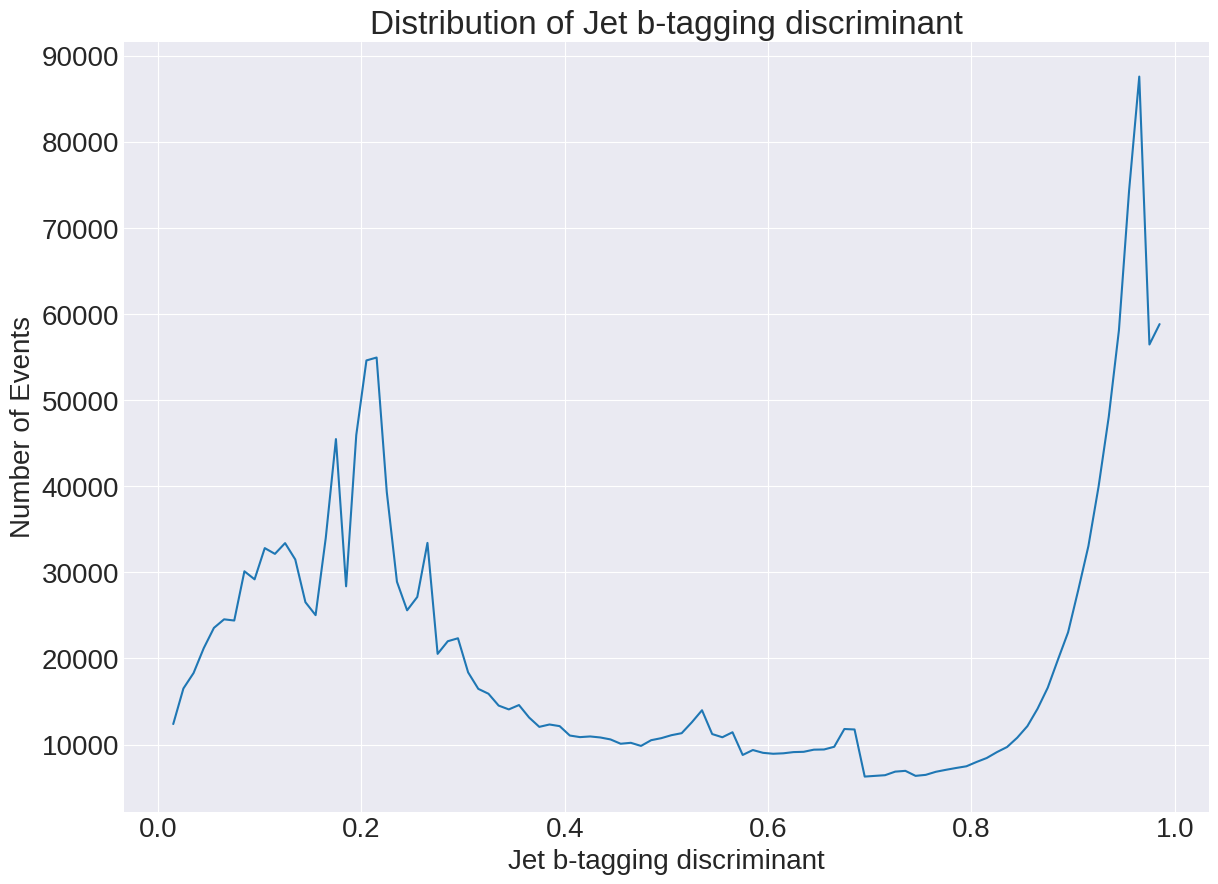

In [36]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["count"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('Jet b-tagging discriminant')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of Jet b-tagging discriminant")

plt.show()

In [38]:
# compute the histogram

min_val = 0
max_val = 200
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = computeHistogram(df_3jets_selected, "triJet_pt_mass_btag.pt", min_val, max_val, num_bins) 


In [39]:
%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 45.2 ms, sys: 17.6 ms, total: 62.7 ms
Wall time: 1min 58s


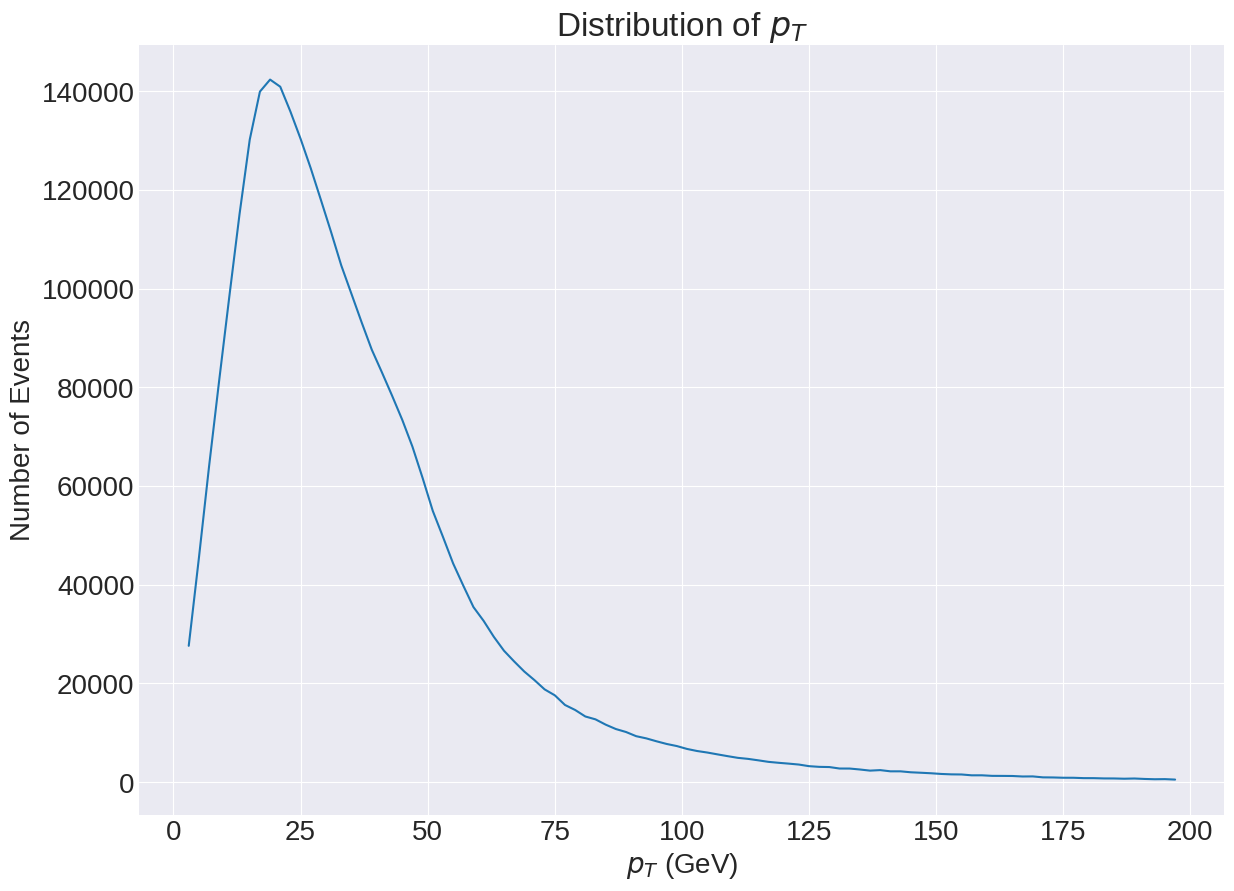

In [40]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["count"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('$p_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of $p_T$ ")

plt.show()

In [ ]:
spark.stop()

## Note on sparkhistogram

Use this to define the computeHistogram function if you cannot ! pip install sparkhistogram

In [ ]:
def computeHistogram(df: "DataFrame", value_col: str, min_val: float, max_val: float, bins: int) -> "DataFrame":
    """ This is a dataframe function to compute the count/frequecy histogram of a column
        
        Parameters
        ----------
        df: the dataframe with the data to compute
        value_col: column name on which to compute the histogram
        min: minimum value in the histogram
        max: maximum value in the histogram
        bins: number of histogram buckets to compute
        
        Output DataFrame
        ----------------
        bucket: the bucket number, range from 1 to bins (included)
        value: midpoint value of the given bucket
        count: number of values in the bucket        
    """
    # Compute the step size for the histogram
    step = (max_val - min_val) / bins

    # Get the Spark Session handle
    spark = SparkSession.getActiveSession()

    # df_buckets is the range of {bins} buckets as requested by the user
    # It will be used to fill in for missing buckets, i.e. buckets with no corresponding values
    df_buckets = spark.range(bins).selectExpr("id + 1 as bucket")

    # Group user data into buckets and count their population count
    df_grouped = (df
                   .selectExpr(f"width_bucket({value_col}, {min_val}, {max_val}, {bins}) as bucket")
                   .groupBy("bucket")
                   .count()
                 )

    # join df_buckets with the grouped data to fill in missing buckets
    df_hist = (df_buckets # note this will be typically broadcasted, the order of the join is important
               .join(df_grouped, "bucket", "left_outer") # add missing buckets and remove buckets out of range
               .selectExpr("bucket", f"{min_val} + (bucket - 0.5) * {step} as value",  # use center value of the buckets
                           "nvl(count, 0) as count") # buckets with no values will have a count of 0
               .orderBy("bucket")
              )

    return df_hist
